In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
# from keras.models import Sequential
# from keras.layers import LSTM, GRU, SimpleRNN
# from keras.layers import Dense, Activation, Dropout
# from keras.layers import Embedding
# from keras.layers import BatchNormalization
# from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
# from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D

In [2]:
# Read the dataset
data = pd.read_csv(r'E:\Data Mining\Spam Detection with LSTM, Bi-LSTM\5000 YT comments.csv', encoding='cp1252')

data.head(2)

,Name,Comment,Time,Likes,Reply Count,Spam
0,Taofeekat,&lt;????i make my first million investing in f...,2022-09-28T02:08:55Z,30,30,1
1,Angelina Jordan,&lt;?l will forever be indebted to you I will ...,2022-09-23T05:26:48Z,0,0,1


In [3]:
from nltk.tokenize import word_tokenize
# import emoji
import re

def _remove_stopword(input_text):
    with open('stop_words_english.txt', 'r', encoding='utf8') as f:
        stop_words = f.readlines()
        stop_words = set(m.strip() for m in stop_words)
        
    words = re.sub(r'[^\w\s]', '', input_text)
    words = word_tokenize(words)
    words = [ch.lower() for ch in words
            if ch.isalpha()
            or ch == '.']
            # or emoji.replace_emoji(ch, replace='') ]
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

In [4]:
data['Comment'] = data['Comment'].apply(_remove_stopword)
data.head(4)

,Name,Comment,Time,Likes,Reply Count,Spam
0,Taofeekat,lti investing forex tradingas beginner time fa...,2022-09-28T02:08:55Z,30,30,1
1,Angelina Jordan,ltl indebted continue preach save huge financi...,2022-09-23T05:26:48Z,0,0,1
2,Fernandez Joe,bi recommend professional forexbitcoin broker ...,2022-09-20T12:56:30Z,5,2,1
3,Jessica Billy,blessed wouldnt met spectacular expert brenda ...,2022-09-17T20:20:24Z,21,34,1


In [5]:
train, temp =  train_test_split(data, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(temp['Comment'].values, 
                                                  temp['Spam'].values,
                                                  random_state=42,
                                                  test_size=2/6, shuffle=True)

X_train, y_train = train['Comment'], train['Spam']

In [7]:
max_features = 3800
maxlen = 365

token = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, oov_token='<OOV>')

token.fit_on_texts(list(X_train) + list(X_val))
X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = sequence.pad_sequences(X_val_seq, maxlen=maxlen)

X_test_seq = token.texts_to_sequences(X_test)
X_test_pad = sequence.pad_sequences(X_test_seq, maxlen=maxlen)

word_index = token.word_index

In [8]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import keyedvectors

glove_input_file = 'glove.6B.50d.txt'
word2vec_output_file = 'glove.6B.50d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

glove_model = keyedvectors.load_word2vec_format(word2vec_output_file, binary=False)

embedding_vector_length = 50
embedding_matrix = np.zeros((max_features+1,  embedding_vector_length))

for word, i in sorted(token.word_index.items(), key=lambda x:x[1]):
    if  i > (max_features+1):
        break
    try:
        embedding_vector = glove_model[word]
        embedding_matrix[i] = embedding_vector
    except:
        pass   

C:\Users\Duc\AppData\Local\Temp\ipykernel_24808\3503899486.py:6: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_input_file, word2vec_output_file)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dropout, LSTM, Dense

model_lstm_cnn = Sequential()
model_lstm_cnn.add(Embedding(max_features+1,
                              embedding_vector_length, 
                              weights=[embedding_matrix],
                              input_length=maxlen,
                              trainable=False))
model_lstm_cnn.add(LSTM(32, return_sequences=True))
model_lstm_cnn.add(Conv1D(32, 3, activation='relu', padding='same'))
model_lstm_cnn.add(MaxPool1D(2))
model_lstm_cnn.add(Dropout(0.2))
model_lstm_cnn.add(Flatten())
model_lstm_cnn.add(Dense(1, activation='sigmoid'))
model_lstm_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_lstm_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 365, 50)           190050    
                                                                 
 lstm (LSTM)                 (None, 365, 32)           10624     
                                                                 
 conv1d (Conv1D)             (None, 365, 32)           3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 182, 32)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 182, 32)           0         
                                                                 
 flatten (Flatten)           (None, 5824)              0         
                                                        

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm_cnn = model_lstm_cnn.fit(X_train_pad, y_train, epochs=10, batch_size=128, 
                                      validation_data=(X_val_pad, y_val), 
                                      callbacks=[early_stopping], 
                                      verbose=2)

Epoch 1/10
24/24 - 6s - loss: 0.6603 - accuracy: 0.5427 - val_loss: 0.6130 - val_accuracy: 0.6672 - 6s/epoch - 251ms/step
Epoch 2/10
24/24 - 4s - loss: 0.5975 - accuracy: 0.7397 - val_loss: 0.5535 - val_accuracy: 0.7046 - 4s/epoch - 160ms/step
Epoch 3/10
24/24 - 4s - loss: 0.5087 - accuracy: 0.7707 - val_loss: 0.4736 - val_accuracy: 0.7781 - 4s/epoch - 163ms/step
Epoch 4/10
24/24 - 4s - loss: 0.4526 - accuracy: 0.8047 - val_loss: 0.4405 - val_accuracy: 0.7976 - 4s/epoch - 157ms/step
Epoch 5/10
24/24 - 4s - loss: 0.4173 - accuracy: 0.8220 - val_loss: 0.4231 - val_accuracy: 0.7976 - 4s/epoch - 149ms/step
Epoch 6/10
24/24 - 4s - loss: 0.3945 - accuracy: 0.8290 - val_loss: 0.4125 - val_accuracy: 0.8141 - 4s/epoch - 158ms/step
Epoch 7/10
24/24 - 4s - loss: 0.3761 - accuracy: 0.8413 - val_loss: 0.4031 - val_accuracy: 0.8291 - 4s/epoch - 155ms/step
Epoch 8/10
24/24 - 4s - loss: 0.3598 - accuracy: 0.8490 - val_loss: 0.3978 - val_accuracy: 0.8321 - 4s/epoch - 154ms/step
Epoch 9/10
24/24 - 4s - 

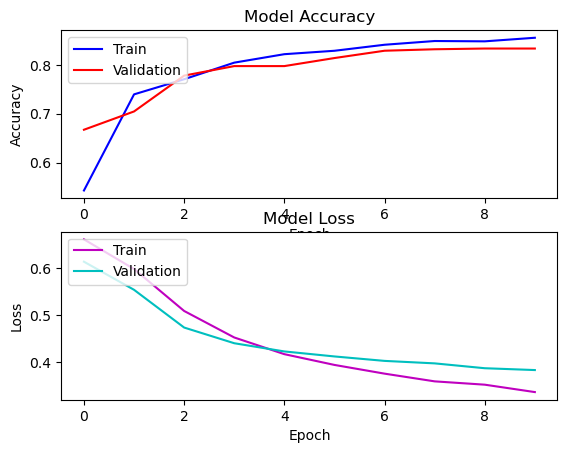

In [11]:
s, (at, al) = plt.subplots(2,1)
at.plot(history_lstm_cnn.history['accuracy'], c= 'b')
at.plot(history_lstm_cnn.history['val_accuracy'], c='r')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(['Train', 'Validation'], loc='upper left')

al.plot(history_lstm_cnn.history['loss'], c='m')
al.plot(history_lstm_cnn.history['val_loss'], c='c')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(['Train', 'Validation'], loc = 'upper left')

CNN - LSTM

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, Dropout, LSTM, Dense

model_cnn_lstm = Sequential()
model_cnn_lstm.add(Embedding(max_features+1,
                             embedding_vector_length, 
                             weights=[embedding_matrix],
                             input_length=maxlen,
                             trainable=False))
model_cnn_lstm.add(Conv1D(32, 3, activation='relu', padding='same'))
model_cnn_lstm.add(MaxPool1D(2))
model_cnn_lstm.add(Dropout(0.2))
model_cnn_lstm.add(LSTM(32, return_sequences=True))
model_cnn_lstm.add(Flatten())
model_cnn_lstm.add(Dense(1, activation='sigmoid'))
model_cnn_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 365, 50)           190050    
                                                                 
 conv1d_1 (Conv1D)           (None, 365, 32)           4832      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 182, 32)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 182, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 182, 32)           8320      
                                                                 
 flatten_1 (Flatten)         (None, 5824)              0         
                                                      

In [13]:
history_cnn_lstm = model_cnn_lstm.fit(X_train_pad, y_train, epochs=10, batch_size=128,
                                    	validation_data=(X_val_pad, y_val), callbacks=[early_stopping], verbose=2)

Epoch 1/10
24/24 - 5s - loss: 0.6327 - accuracy: 0.6690 - val_loss: 0.5873 - val_accuracy: 0.7346 - 5s/epoch - 188ms/step
Epoch 2/10
24/24 - 2s - loss: 0.5668 - accuracy: 0.7330 - val_loss: 0.5516 - val_accuracy: 0.7166 - 2s/epoch - 93ms/step
Epoch 3/10
24/24 - 2s - loss: 0.5083 - accuracy: 0.7687 - val_loss: 0.4896 - val_accuracy: 0.7766 - 2s/epoch - 88ms/step
Epoch 4/10
24/24 - 2s - loss: 0.4640 - accuracy: 0.8037 - val_loss: 0.4540 - val_accuracy: 0.8066 - 2s/epoch - 90ms/step
Epoch 5/10
24/24 - 2s - loss: 0.4286 - accuracy: 0.8167 - val_loss: 0.4338 - val_accuracy: 0.8111 - 2s/epoch - 90ms/step
Epoch 6/10
24/24 - 2s - loss: 0.4122 - accuracy: 0.8237 - val_loss: 0.4222 - val_accuracy: 0.8126 - 2s/epoch - 90ms/step
Epoch 7/10
24/24 - 2s - loss: 0.3993 - accuracy: 0.8333 - val_loss: 0.4184 - val_accuracy: 0.8231 - 2s/epoch - 89ms/step
Epoch 8/10
24/24 - 2s - loss: 0.3828 - accuracy: 0.8380 - val_loss: 0.4078 - val_accuracy: 0.8216 - 2s/epoch - 88ms/step
Epoch 9/10
24/24 - 2s - loss: 0

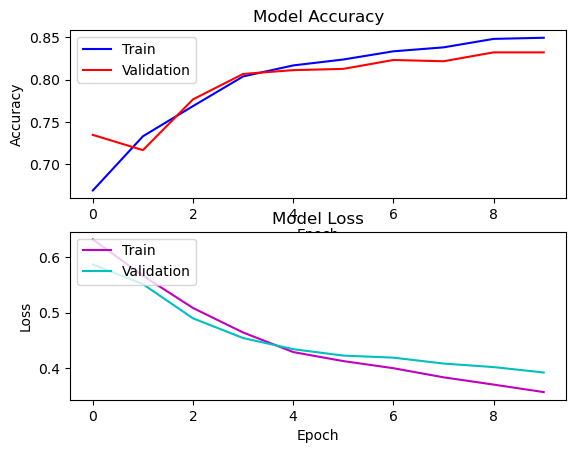

In [14]:
s, (at, al) = plt.subplots(2,1)
at.plot(history_cnn_lstm.history['accuracy'], c= 'b')
at.plot(history_cnn_lstm.history['val_accuracy'], c='r')
at.set_title('Model Accuracy')
at.set_ylabel('Accuracy')
at.set_xlabel('Epoch')
at.legend(['Train', 'Validation'], loc='upper left')

al.plot(history_cnn_lstm.history['loss'], c='m')
al.plot(history_cnn_lstm.history['val_loss'], c='c')
al.set_title('Model Loss')
al.set_ylabel('Loss')
al.set_xlabel('Epoch')
al.legend(['Train', 'Validation'], loc = 'upper left')

42/42 [==============================] - 1s 12ms/step


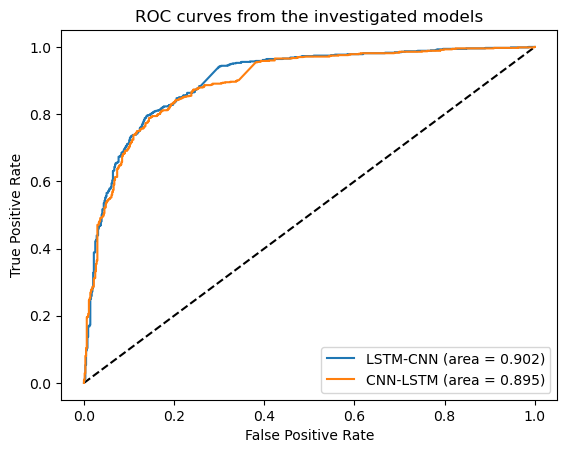

In [15]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

pred_lstm_cnn = model_lstm_cnn.predict(X_test_pad)
fpr_lstm_cnn, tpr_lstm_cnn, thresholds_lstm_cnn = roc_curve(y_test, pred_lstm_cnn)
roc_auc_lstm_cnn = auc(fpr_lstm_cnn, tpr_lstm_cnn)

pred_cnn_lstm = model_cnn_lstm.predict(X_test_pad)
fpr_cnn_lstm, tpr_cnn_lstm, thresholds_cnn_lstm = roc_curve(y_test, pred_cnn_lstm)
roc_auc_cnn_lstm = auc(fpr_cnn_lstm, tpr_cnn_lstm)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lstm_cnn, tpr_lstm_cnn, label='LSTM-CNN (area = %0.3f)' % roc_auc_lstm_cnn)
plt.plot(fpr_cnn_lstm, tpr_cnn_lstm, label='CNN-LSTM (area = %0.3f)' % roc_auc_cnn_lstm)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves from the investigated models')
plt.legend(loc='best')
plt.show()